In [62]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings("ignore")

Reading the training dataset

In [2]:
training_dataset = pd.read_csv('./new_files/training_dataset.csv')
training_dataset

,0,1,2,3,4,5,6,7,8,9,...,175,176,177,178,179,condition,sampleID,targetID,status,unknown
0,6682,6839,7024,6978,7344,7545,7762,7709,7909,8302,...,1650697,1651206,1652638,1650117,1653470,ConditionA,known0,m0,present,N
1,-3646,-3738,-3571,-3285,-3261,-3125,-2912,-2945,-2793,-2650,...,1538270,1538191,1538860,1541810,1543724,ConditionA,known0,m1,absent,N
2,-9858,-10172,-9823,-10032,-9800,-9705,-9726,-9522,-9253,-9410,...,486117,487310,487487,490208,489975,ConditionA,known0,m2,absent,N
3,-7028,-7014,-6626,-6298,-5914,-5823,-5113,-4672,-4673,-4277,...,630051,632690,635985,639871,641474,ConditionA,known0,m3,absent,N
4,-13598,-13571,-12694,-13877,-12837,-13611,-12894,-12854,-13782,-12957,...,964470,969083,965359,969566,968247,ConditionA,known0,m4,absent,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,-2927,-2685,-5044,-5308,-6058,-6925,-8419,-9343,-10555,-10684,...,331409,333018,332833,334156,335345,ConditionC,known31,m27,absent,N
3068,6708,7148,7559,8126,8400,8985,9337,10069,10620,10752,...,328266,328363,329084,329398,331176,ConditionC,known31,m28,absent,N
3069,4571,4807,5100,4055,4719,5048,4509,4871,4840,5176,...,1270247,1269780,1267836,1273148,1268565,ConditionC,known31,m29,absent,N
3070,1295,1177,-2700,-5548,-6613,-6765,-10188,-9327,-14282,-14529,...,595430,596663,599407,599909,603275,ConditionC,known31,m30,absent,N


In [21]:
labels_set = training_dataset['status']
training_subset = training_dataset.drop(columns=['unknown', 'status', 'sampleID'])

In [14]:
unique_conditions = training_dataset.condition.unique()
unique_targets = training_dataset.targetID.unique()

The plot for the data shows that it is possible to define a certain absolute threshold that can easily determine the presence of mutation in the sample. To find that threshold, we can use Linear regeression and Decision Tree models.

## 1. Simple method - calculating threshold (Find the time ("Cq") at which each curve crosses a fixed signal threshold.)

1. For each target and condition, use the known samples to define a time threshold.
2. Consider mutations to be present if their Cq is before this time threshold, and absent if after it.

Eg: Condition A , m13 => Cq = 43


In [ ]:
# training_dataset.query(f'condition == "ConditionA" and targetID =="m1"')
# subset = training_dataset.query(f'condition == "ConditionA" and targetID =="m1" and status == "present"')
# subset.transpose()

Basically the idea is to find a certain time (s) at which we can ascertain if the sample has a mutation based on the amplitude of the fluorescence. From the plot, we can understand that the signal amplitude for samples with mutatations is atlast 0.1e5. But this is true only for 'Condition A' and target 'm1'. Assuming this could be true for all the conditions and target mutations, we use 100000 (0.1e6) as the fixed signal threshold that needs to be crossed early to determine the presence of mutations. The following method find_Cq_fixed is used to define Cq values for each condition and target.

In [10]:
def find_Cq_fixed():
    
    list_thresholds=[]
    fixed_signal_threshold = 100000

    for cond in unique_conditions:
        for target in unique_targets:
            # print(cond, target)
            subset = training_dataset.query(f'condition == "{cond}" and targetID =="{target}"')
            subset_present = subset[subset.status == 'present']
            subset_absent = subset[subset.status == 'absent']
            
            signalthreshold = -1
            timethreshold = -1
            
            # select the columns with amplitude data only and converting the columns to rows
            subset_present = subset_present.iloc[:,:180].transpose()
            subset_absent = subset_absent.iloc[:,:180].transpose()

            # Find the minimum amplitude from the subset of 
            # For each row (here the row is a time/second (s)) of observation), we find 
            # 1. the minimum amplitude in for the present samples
            # 2. the maximum amplitude in for the absent samples

            # This way we can safely differentiate between the present and absent mutations based on the amplitude value at Cq time.

            subset_present['min_signal'] = subset_present.min(axis=1)
            min_signal_list = subset_present.min(axis=1).to_list()
            # print(min_signal_list)

            subset_absent['max_signal'] = subset_absent.max(axis=1)
            max_signal_list = subset_absent.max(axis=1).to_list()
            
            # Go through the list of minimums and maximums to find the Cq when all the samples with mutations present are above the fixed signal threshold and all the samples with absent mutations are below it.
            # TODO: This can be further spaced out with a range to determine a sort of confidence interval.

            for i in range(len(min_signal_list)-1):
                if min_signal_list[i] > fixed_signal_threshold and max_signal_list[i] < fixed_signal_threshold:
                    signalthreshold = fixed_signal_threshold
                    timethreshold= i
                    break
                
            list_thresholds.append([cond, target, signalthreshold, timethreshold])
    return list_thresholds

Taking inspiration from the above method, I have defined another function that determines Cq based on a difference between the maximum and minumum amplitudes. Instead of depending on the fixed signal threshold (100000) across all 3 conditions & 32 targets, I have decided to use this threshold to be the difference so that we have a higher confidence in determining the mutation. For example, in Condition C, target m31, some of the present and the absent samples cross the absolute signal threshold very close to each other. In such cases, using a fixed amplitude threshold is not the most useful.  

The following method find_Cq(diff_threshold) was used to get new Cq values for each condition and target with this above logic.

In [11]:
def find_Cq(diff_threshold):
    list_thresholds=[]
    for cond in unique_conditions:
        for target in unique_targets:
            # print(cond, target)
            subset = training_dataset.query(f'condition == "{cond}" and targetID =="{target}"')
            subset_present = subset[subset.status == 'present']
            subset_absent = subset[subset.status == 'absent']
            
            signalthreshold = -1
            timethreshold = -1
            
            # select the columns with amplitude data only and converting the columns to rows
            subset_present = subset_present.iloc[:,:180].transpose()
            subset_absent = subset_absent.iloc[:,:180].transpose()

            # Find the minimum amplitude from the subset of 
            # For each row (here the row is a time/second (s)) of observation)

            subset_present['min_signal'] = subset_present.min(axis=1)
            min_signal_list = subset_present.min(axis=1).to_list()
            # print(min_signal_list)

            subset_absent['max_signal'] = subset_absent.max(axis=1)
            max_signal_list = subset_absent.max(axis=1).to_list()
            
            for i in range(len(min_signal_list)-1):
                diff_amplitudes = min_signal_list[i] - max_signal_list[i]
                if diff_amplitudes > diff_threshold:
                    # print(i, min_signal_list[i], min_signal_list[i] - max_signal_list[i])
                    signalthreshold = min_signal_list[i]
                    timethreshold= i
                    break
            list_thresholds.append([cond, target, signalthreshold, timethreshold])
    return list_thresholds

In [12]:
# Compute and save Cq values to csv - find_Cq_fixed

list_fixed_thresholds = find_Cq_fixed()
fixed_thresholds = pd.DataFrame(list_fixed_thresholds, columns=['Condition', 'targetID', 'signal_threshold', 'time_threshold(Cq)'])
fixed_thresholds.to_csv('./new_files/thresholds_fixed.csv')

In [123]:
# list_thresholds_50000 = find_Cq(50000)
# thresholds_50000 = pd.DataFrame(list_thresholds_50000, columns=['Condition', 'targetID', 'signal_threshold', 'time_threshold(Cq)'])
# thresholds_50000.to_csv('./new_files/thresholds_50000.csv')

In [13]:
# Compute and save Cq values to csv - find_Cq

def save_thresholds(threshold_diff = 10000):
    list_thresholds = find_Cq(threshold_diff)
    thresholds = pd.DataFrame(list_thresholds, columns=['Condition', 'targetID', 'signal_threshold', 'time_threshold(Cq)'])
    thresholds.to_csv(f'./new_files/thresholds_{threshold_diff}.csv')
    return thresholds

### Save thresholds

In [126]:
save_thresholds(100000)

,Condition,targetID,signal_threshold,time_threshold(Cq)
0,ConditionA,m0,166871,76
1,ConditionA,m1,192540,68
2,ConditionA,m2,170161,34
3,ConditionA,m3,187716,39
4,ConditionA,m4,175071,57
...,...,...,...,...
91,ConditionC,m27,157590,83
92,ConditionC,m28,188039,74
93,ConditionC,m29,180074,50
94,ConditionC,m30,100982,75


## 2. Machine Learning Method

For this dataset, I have decided to use a standard version of the Decision Tree and Ensemble model to determine the presence of mutation. There are several key factors behind this decision - 

1. Decision tress are great for explainability of the predicted results which are a significant part of AI ethics when working with health care data. As these results are going to impact human lives, we should not rely on black-box algorithms to make decisions/ conclusions that cannot be arrived at independently.

2. If a simple solution works, there is no need to complicate it. This is also good for computational limitations.

3. This dataset is small and can be trained quickly.

4. Introducing new features and retraining can be done quickly due to the small dataset, and also we can retreieve feature importances to understand what are the key factors in determining the presence of mutation. For example, from plot1.png, the skeweness of the dataset at Cq could be an useful feature.

A couple of limitations to consider - 

1. They lag in performance, particularly in terms of generalization to different/ unseen data. Therefore it is important to validate this model against different kinds of data as well as retrain it with new data. For example, if we introduce a new assay 'Condition D', the model has a higher chance of failing to preform well.

2. They are prone to overfitting on the seen dataset. And this can be problematic if new dataset doesn't follow the same distribution.



In [45]:
import sklearn as skl
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score

In [89]:
training_dataset = pd.read_csv(f'./new_files/training_dataset.csv')
training_dataset

,0,1,2,3,4,5,6,7,8,9,...,175,176,177,178,179,condition,sampleID,targetID,status,unknown
0,6682,6839,7024,6978,7344,7545,7762,7709,7909,8302,...,1650697,1651206,1652638,1650117,1653470,ConditionA,known0,m0,present,N
1,-3646,-3738,-3571,-3285,-3261,-3125,-2912,-2945,-2793,-2650,...,1538270,1538191,1538860,1541810,1543724,ConditionA,known0,m1,absent,N
2,-9858,-10172,-9823,-10032,-9800,-9705,-9726,-9522,-9253,-9410,...,486117,487310,487487,490208,489975,ConditionA,known0,m2,absent,N
3,-7028,-7014,-6626,-6298,-5914,-5823,-5113,-4672,-4673,-4277,...,630051,632690,635985,639871,641474,ConditionA,known0,m3,absent,N
4,-13598,-13571,-12694,-13877,-12837,-13611,-12894,-12854,-13782,-12957,...,964470,969083,965359,969566,968247,ConditionA,known0,m4,absent,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3067,-2927,-2685,-5044,-5308,-6058,-6925,-8419,-9343,-10555,-10684,...,331409,333018,332833,334156,335345,ConditionC,known31,m27,absent,N
3068,6708,7148,7559,8126,8400,8985,9337,10069,10620,10752,...,328266,328363,329084,329398,331176,ConditionC,known31,m28,absent,N
3069,4571,4807,5100,4055,4719,5048,4509,4871,4840,5176,...,1270247,1269780,1267836,1273148,1268565,ConditionC,known31,m29,absent,N
3070,1295,1177,-2700,-5548,-6613,-6765,-10188,-9327,-14282,-14529,...,595430,596663,599407,599909,603275,ConditionC,known31,m30,absent,N


In [90]:
training_condA = training_dataset[training_dataset['condition'] == 'ConditionA']
training_condB = training_dataset[training_dataset['condition'] == 'ConditionB']
training_condC = training_dataset[training_dataset['condition'] == 'ConditionC']

#### Training functions

In [7]:
def print_ml_metrics(predicted_labels, y_test):
    print(f'accuracy: {skl.metrics.accuracy_score(y_pred = predicted_labels, y_true=y_test)}')
    print(f"precision: {skl.metrics.precision_score(y_pred = predicted_labels, y_true=y_test, pos_label='present')}")
    print(f'recall: {skl.metrics.recall_score(y_pred = predicted_labels, y_true=y_test, pos_label="present")}')

In [88]:
import matplotlib.pyplot as plt

In [87]:
def train_DT_classifier(training_subset, last_col_idx = 180):
    """
    This method trains a default, generic Decision Tree classifier on the data provided, evaluates the fit on known test samples (technically validation samples), and prints the accuracy, precision and recall scores for the classifier.
    
    Args:
        - training_subset: the training dataset
        - last_col_idx: Index of the last column in the training dataset that is to be considered while training. Default = 180 (when using the curves.csv dataset)
    Returns:
        - The trained DecisionTreeClassifer() model
    Notes:
        - We use gini criteria and limit the max_depth of the decision tree to be 5 to reduce the chances of overfitting to the data. This is also a hyperparameter that can be tuned for further develpoment.

    """

    X_train, X_test, y_train, y_test = train_test_split(training_subset.iloc[:, :last_col_idx], training_subset['status'], test_size=0.3, random_state=42)
    dtc = DecisionTreeClassifier(criterion='gini', max_depth=5)
    starttime = time.time()
    dtc.fit(X=X_train, y=y_train)
    plt.figure(figsize=(20,12))
    skl.tree.plot_tree(dtc)
    endtime = time.time()
    print(f'Time taken for training = {endtime-starttime} seconds')
    y_pred = dtc.predict(X_test)
    print_ml_metrics(y_pred, y_test)
    return dtc

### Training on time-series data

In this section, we train the model on the entire dataset without any categorical columns and purely on the curves data.

Condition = ConditionA
Time taken for training = 0.2515690326690674 seconds
accuracy: 0.9512987012987013
precision: 0.8536585365853658
recall: 0.7954545454545454
-------------------------------------
Condition = ConditionB
Time taken for training = 0.1981804370880127 seconds
accuracy: 0.9415584415584416
precision: 0.825
recall: 0.75
-------------------------------------
Condition = ConditionC
Time taken for training = 0.2230520248413086 seconds
accuracy: 0.9577922077922078
precision: 0.8444444444444444
recall: 0.8636363636363636
-------------------------------------
Training all of conditions together
Time taken for training = 0.39731597900390625 seconds
accuracy: 0.940347071583514
precision: 0.8222222222222222
recall: 0.6548672566371682


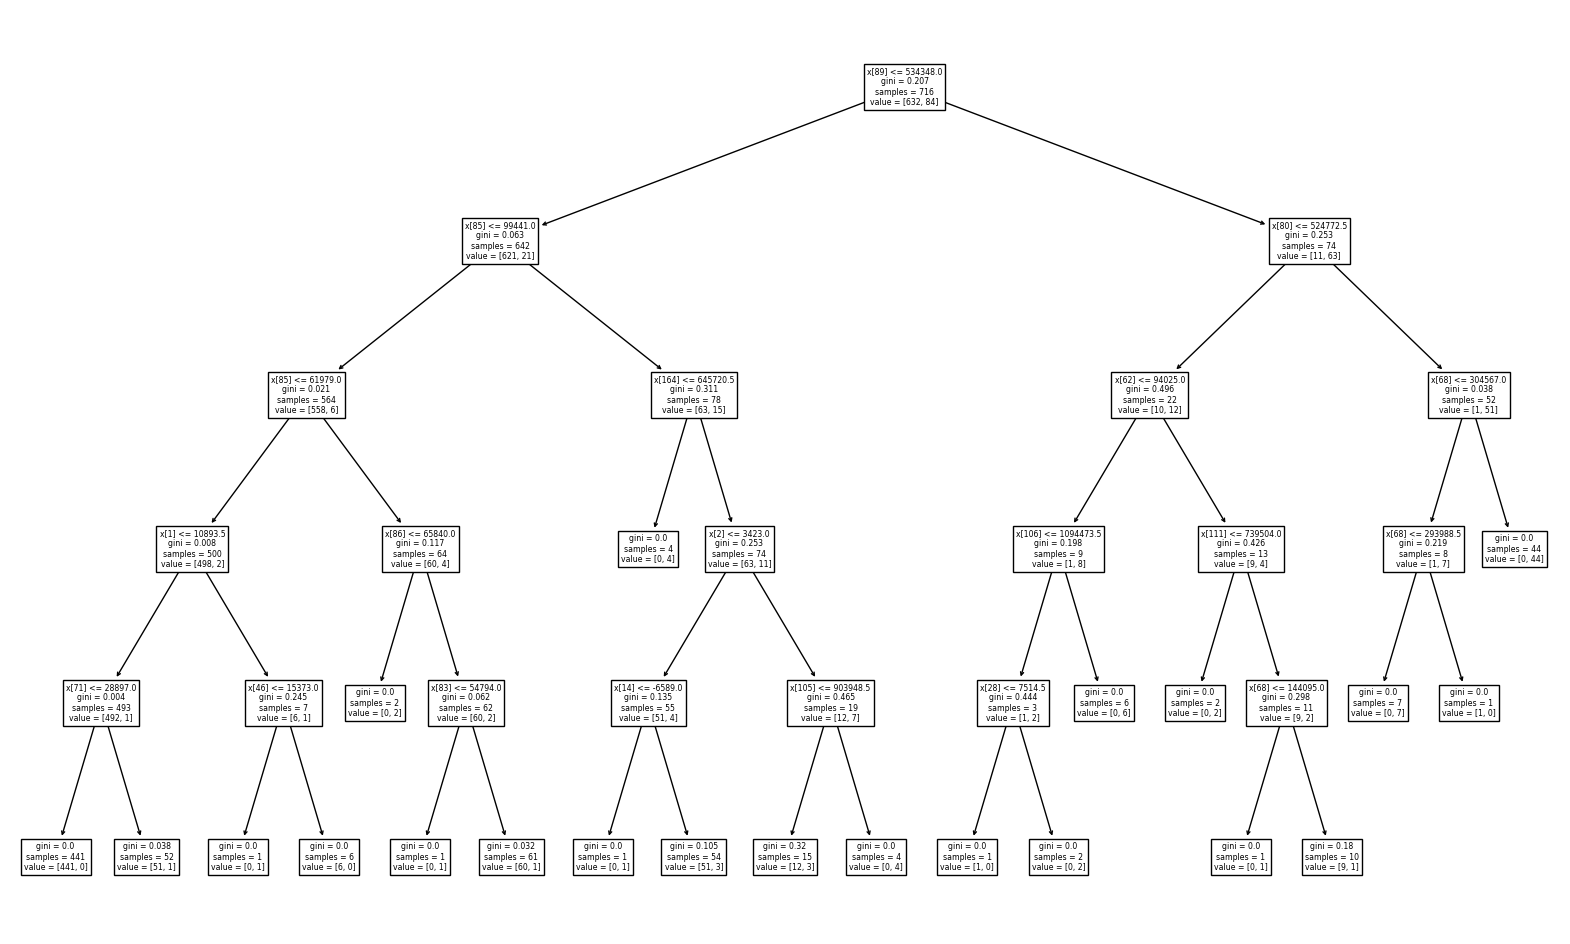

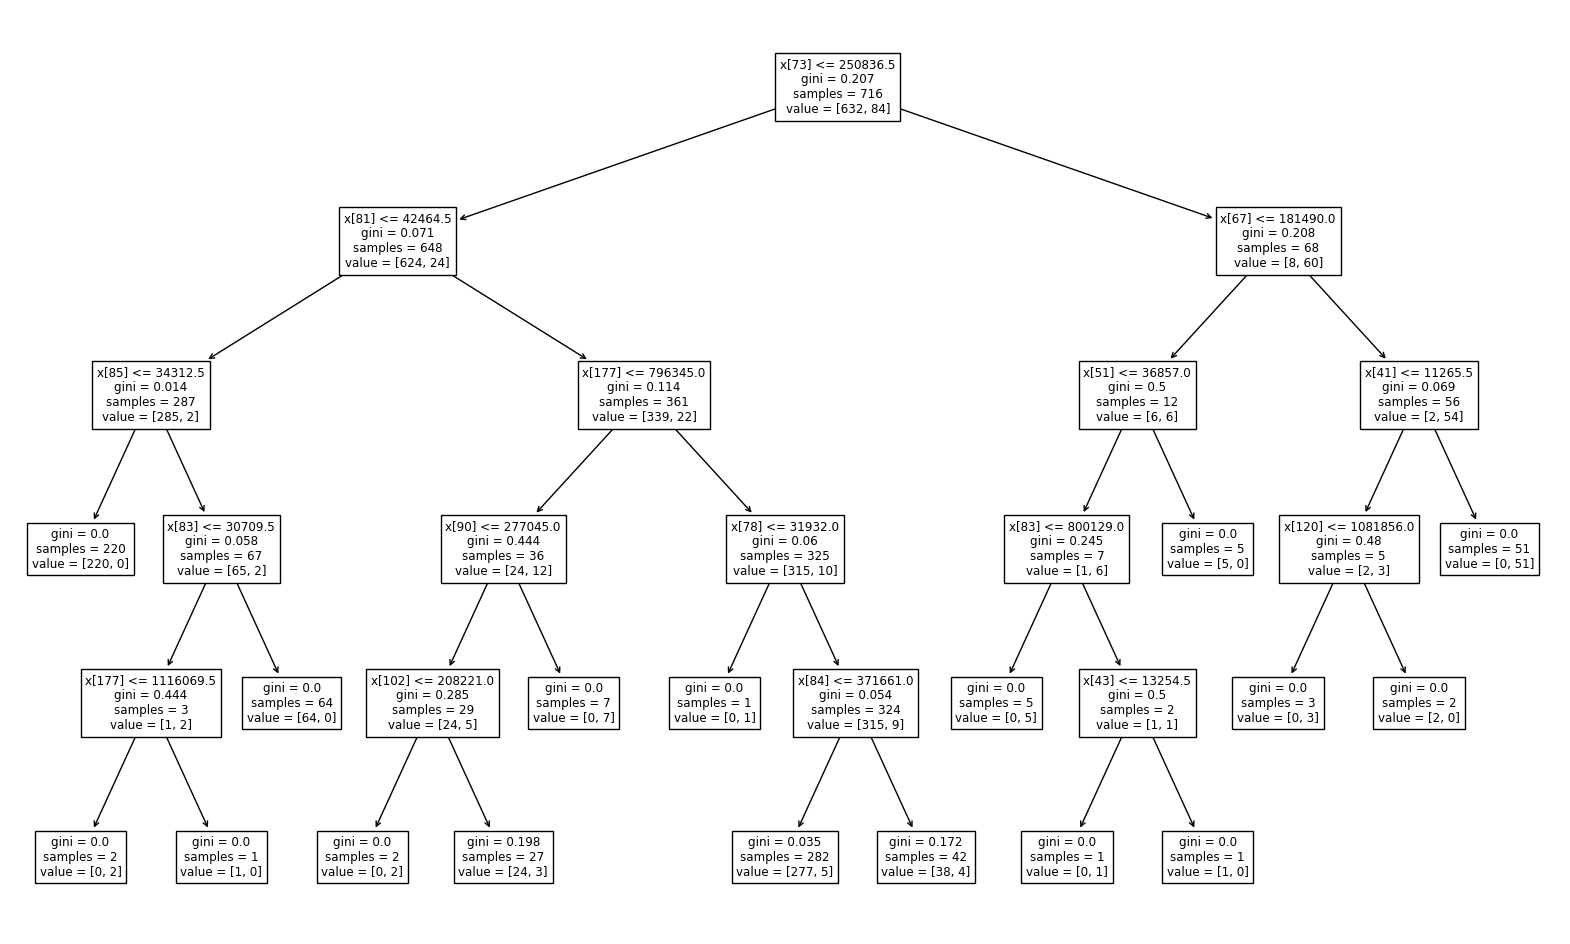

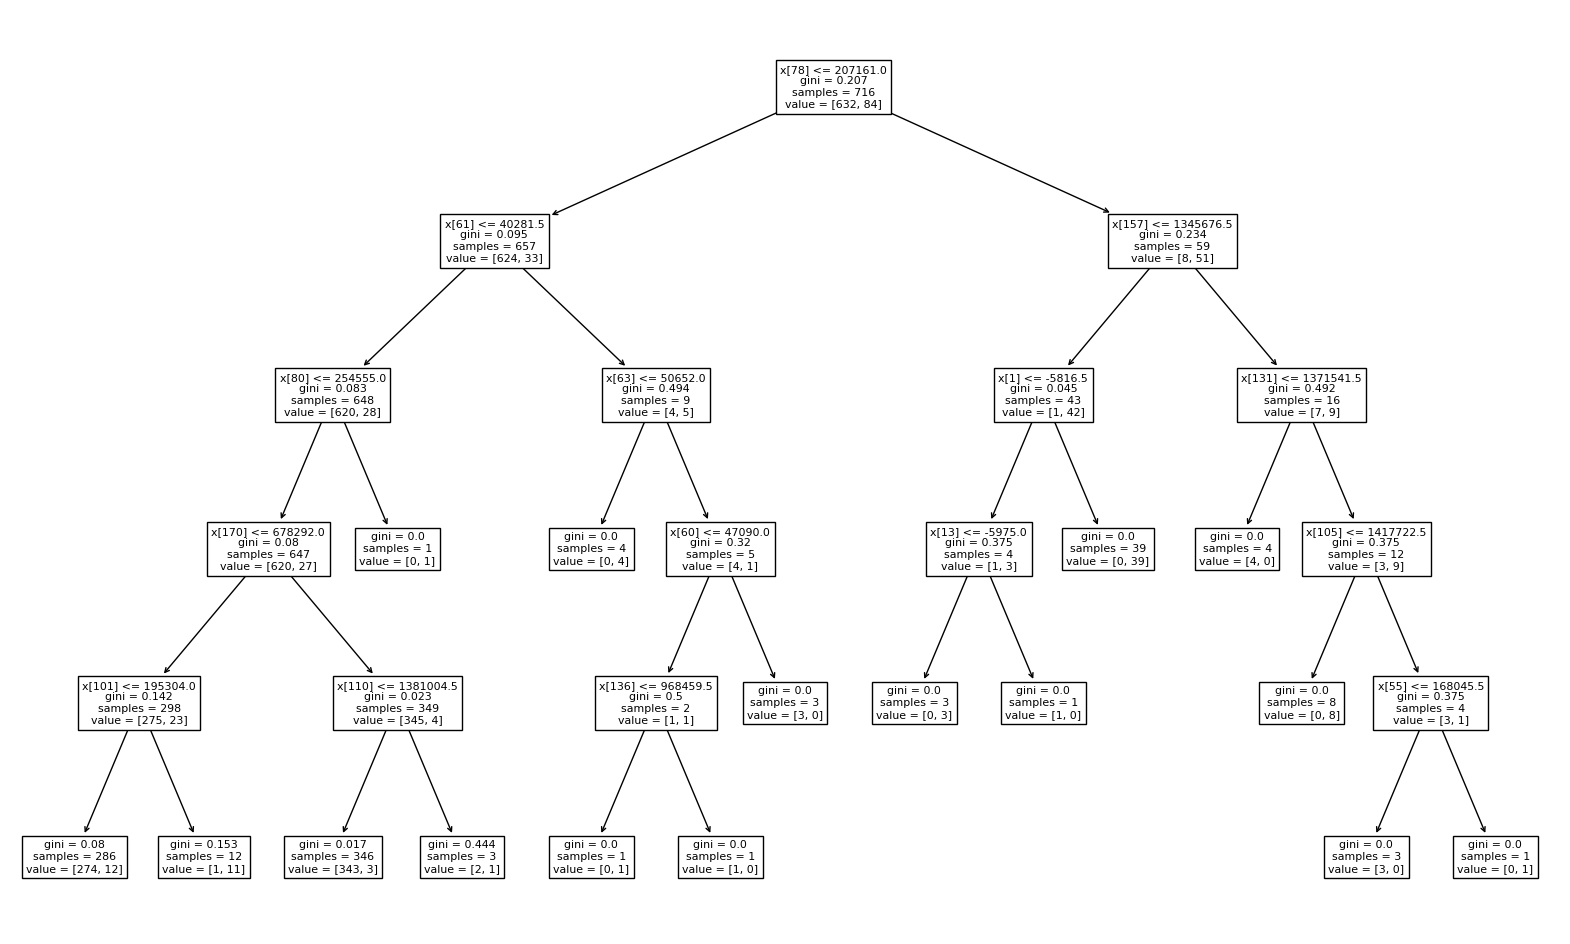

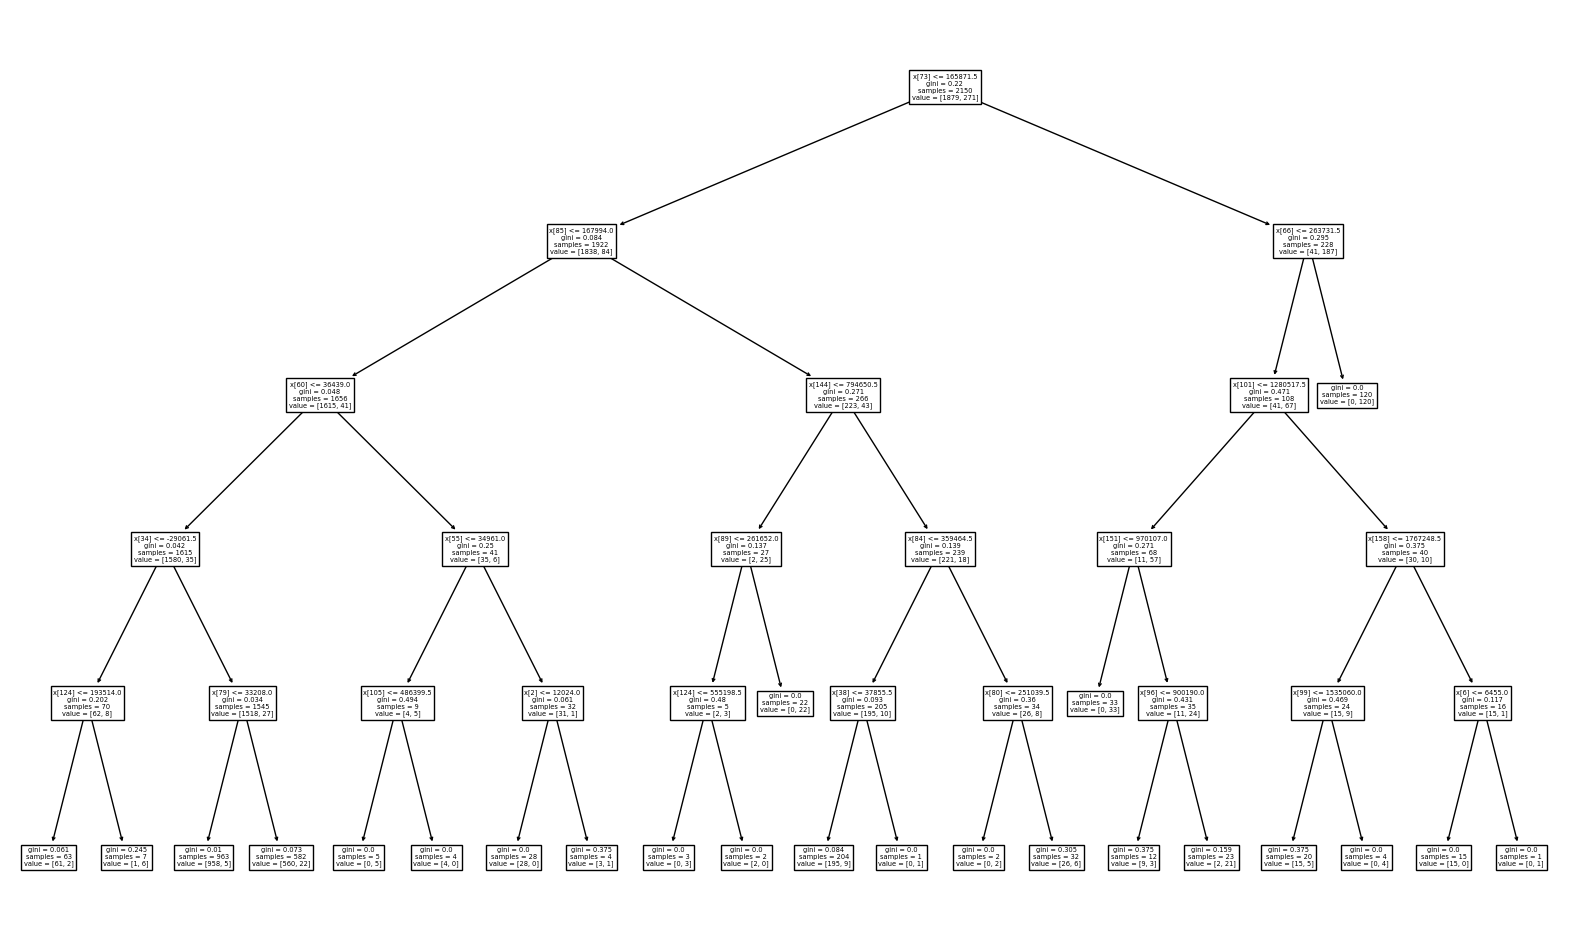

In [91]:
tree_classifiers = []
for cond in unique_conditions:
    training_cond = training_dataset[training_dataset['condition'] == cond]
    print(f'Condition = {cond}')
    cond_tree = train_DT_classifier(training_cond)
    tree_classifiers.append(cond_tree)
    print("-------------------------------------")
    
print("Training all of conditions together")
all_cond_tree = train_DT_classifier(training_dataset)

#### Test ML model

In [32]:
cross_val_score(all_cond_tree, X=training_dataset.iloc[:, :180], y=training_dataset['status'])

array([0.9398374 , 0.94796748, 0.95439739, 0.94788274, 0.95114007])

In [35]:
cross_val_score(tree_classifiers[0], X=training_condA.iloc[:, :180], y=training_condA['status'])

array([0.93170732, 0.96585366, 0.94146341, 0.94146341, 0.93627451])

In [39]:
cross_val_score(tree_classifiers[1], X=training_condB.iloc[:, :180], y=training_condB['status'])

array([0.96097561, 0.93170732, 0.94634146, 0.94146341, 0.96568627])

In [38]:
cross_val_score(tree_classifiers[2], X=training_condC.iloc[:, :180], y=training_condC['status'])

array([0.92682927, 0.92195122, 0.93170732, 0.95121951, 0.95588235])

#### Save models

In [41]:
import joblib

In [43]:
joblib.dump(all_cond_tree, filename="./new_files/model_all_data.joblib")
joblib.dump(tree_classifiers[0], filename="./new_files/model_condA.joblib")
joblib.dump(tree_classifiers[1], filename="./new_files/model_condB.joblib")
joblib.dump(tree_classifiers[2], filename="./new_files/model_condC.joblib")

['./new_files/model_condC.joblib']

### Training on new features only

In this exercise, I am using the new features - skewness and median - for training the dataset.

In [71]:
full_dataset_fe = pd.read_csv(f'./new_files/full_dataset_fe.csv')
full_dataset_fe

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,177,178,179,condition,sampleID,targetID,status,unknown,skewness,median
0,0,6682,6839,7024,6978,7344,7545,7762,7709,7909,...,1652638,1650117,1653470,ConditionA,known0,m0,present,N,0.258930,6682.0
1,1,-3646,-3738,-3571,-3285,-3261,-3125,-2912,-2945,-2793,...,1538860,1541810,1543724,ConditionA,known0,m1,absent,N,0.751585,-3646.0
2,2,-9858,-10172,-9823,-10032,-9800,-9705,-9726,-9522,-9253,...,487487,490208,489975,ConditionA,known0,m2,absent,N,1.260830,-9858.0
3,3,-7028,-7014,-6626,-6298,-5914,-5823,-5113,-4672,-4673,...,635985,639871,641474,ConditionA,known0,m3,absent,N,2.408515,-7028.0
4,4,-13598,-13571,-12694,-13877,-12837,-13611,-12894,-12854,-13782,...,965359,969566,968247,ConditionA,known0,m4,absent,N,1.239806,-13598.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,4603,5653,3804,3083,2565,2359,977,871,-65,340,...,325421,323636,325362,ConditionC,unknown15,m27,unknown,Y,1.184890,5653.0
4604,4604,-4106,-3453,-3324,-2522,-2020,-1563,-747,33,-230,...,358238,360666,361211,ConditionC,unknown15,m28,unknown,Y,1.376768,-4106.0
4605,4605,-4093,-3646,-3801,-3700,-3602,-4113,-3977,-3586,-4383,...,1272485,1274315,1275310,ConditionC,unknown15,m29,unknown,Y,0.095508,-4093.0
4606,4606,-2631,-4923,-6903,-9539,-7456,-11478,-11924,-12757,-17251,...,587793,587841,589416,ConditionC,unknown15,m30,unknown,Y,1.775441,-2631.0


In [72]:
training_dataset = full_dataset_fe[full_dataset_fe.unknown == 'N']
test_dataset = full_dataset_fe[full_dataset_fe.unknown == 'Y']

Condition = ConditionA
Time taken for training = 0.19984674453735352 seconds
accuracy: 0.9512987012987013
precision: 0.9142857142857143
recall: 0.7272727272727273
-------------------------------------
Condition = ConditionB
Time taken for training = 0.10982561111450195 seconds
accuracy: 0.9448051948051948
precision: 0.8461538461538461
recall: 0.75
-------------------------------------
Condition = ConditionC
Time taken for training = 0.08912849426269531 seconds
accuracy: 0.9285714285714286
precision: 0.75
recall: 0.75
-------------------------------------
Training all of conditions together
Time taken for training = 0.13709402084350586 seconds
accuracy: 0.9446854663774403
precision: 0.8163265306122449
recall: 0.7079646017699115


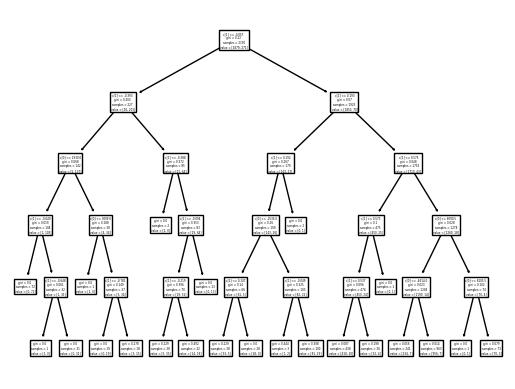

In [74]:
tree_classifiers = []
training_dataset = training_dataset[['median', 'skewness', 'condition', 'status']]
for cond in unique_conditions:
    training_cond = training_dataset[training_dataset['condition'] == cond]
    print(f'Condition = {cond}')
    cond_tree = train_DT_classifier(training_cond, last_col_idx=2)
    tree_classifiers.append(cond_tree)
    print("-------------------------------------")
    
print("Training all of conditions together")
all_cond_tree = train_DT_classifier(training_dataset, last_col_idx=2)

#### Test ML model

Here we get the cross validation scores for each condition as well as the entire dataset. I have used the default cross validation method i.e., 5-fold cross validation for quick use along with the accuracy, precision and recall scores for each of the classifiers. The cross validation method returns an array of accuracy scores for each training and validation subset and for ease of use, I am using the average of those acurracy scores to see which classifier is better.

In [76]:
training_condA = training_dataset[training_dataset['condition'] == 'ConditionA']
training_condB = training_dataset[training_dataset['condition'] == 'ConditionB']
training_condC = training_dataset[training_dataset['condition'] == 'ConditionC']

In [79]:
cross_val_score(all_cond_tree, X=training_dataset.iloc[:, :2], y=training_dataset['status']).mean()

0.9394454596011759

In [80]:
cross_val_score(tree_classifiers[0], X=training_condA.iloc[:, :2], y=training_condA['status']).mean()

0.9463079866092778

In [81]:
cross_val_score(tree_classifiers[1], X=training_condB.iloc[:, :2], y=training_condB['status']).mean()

0.9502152080344333

In [82]:
cross_val_score(tree_classifiers[2], X=training_condC.iloc[:, :2], y=training_condC['status']).mean()

0.9179961740793878

#### Save models

In [75]:
joblib.dump(all_cond_tree, filename="./new_files/model_all_data_fe.joblib")
joblib.dump(tree_classifiers[0], filename="./new_files/model_condA_fe.joblib")
joblib.dump(tree_classifiers[1], filename="./new_files/model_condB_fe.joblib")
joblib.dump(tree_classifiers[2], filename="./new_files/model_condC_fe.joblib")

['./new_files/model_condC_fe.joblib']